# QRS Complex Dectition Algorithm


## Acquiring the Data

In [1187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset with comma as delimiter
df = pd.read_csv("lab5_Philco-L05.txt", delimiter=",")

df = df

df.head()

,sec,CH1,CH40,Unnamed: 3
0,0.000,-0.120850,0.0,NaN
1,0.001,-0.123596,0.0,NaN
2,0.002,-0.126343,0.0,NaN
3,0.003,-0.129395,0.0,NaN
4,0.004,-0.131836,0.0,NaN


## Cleaning the Dataset

In [1188]:
# Removing unnecessary columns
df = df.drop('Unnamed: 3', axis=1) # Unnecessary
df = df.drop('CH40', axis=1)

# Only use the first 40,000 entries
df_subset = df.iloc[:40000]

df.head()

,sec,CH1
0,0.000,-0.120850
1,0.001,-0.123596
2,0.002,-0.126343
3,0.003,-0.129395
4,0.004,-0.131836


## Rate of Change Function
This function gets the first and second derivative of the original given signal and adds their absolute components together, to take a look at the rate of change of the data. The QRS component of each beat can be identified by the largest peakls in the plot. 

The function steps:
--> Gets first derivative
--> Gets second derivative
--> Adds absolute values of first and second derivative
--> Transnforms to frequency domain
--> applies a low pass filter to the data
--> return to time domain
--> plots the rate of change
--> returns both x and y components of the rate of change plot

In [1189]:
def rate_of_change(signal_x, signal_y):

    # remove dc component
    signal_y = signal_y - np.sum(signal_y)/len(signal_y)

    # Compute the first derivative
    first_derivative = np.gradient(signal_y, signal_x)

    # Compute the second derivative
    second_derivative = np.gradient(first_derivative, signal_x)

    roc_data = abs(first_derivative) + abs(second_derivative)

    # Find the frequency domain components
    fft_result = np.fft.fft(roc_data)

    # Compute the frequencies corresponding to the FFT result
    n = len(roc_data)
    dt = np.diff(signal_x).mean()  # Calculate the mean time step
    freq = np.fft.fftfreq(n, d=dt)  # Compute the frequency array

    # Define the cutoff frequency for the low-pass filter
    cutoff_freq = 50  # Adjust this value according to your requirements

    # Create the low-pass filter
    lowpass_filter = np.zeros_like(freq)
    lowpass_filter[np.abs(freq) <= cutoff_freq] = 1

    # Apply the low-pass filter to the FFT result
    filtered_fft_result = fft_result * lowpass_filter

    # Compute the inverse FFT (return to time domain)
    ifft_result = np.fft.ifft(filtered_fft_result)

    return signal_x, np.real(ifft_result)

## QRS Detection

In [1190]:
import random
def qrs_detection(x_data, y_data):
  
    window_size = 500

    # Randomly select three starting indices for the windows
    start_indices = [random.randint(0, len(y_data) - window_size) for _ in range(3)]

    # Initialize lists to store the maximum and minimum values from each window
    max_values = []
    min_values = []

    # Iterate over the starting indices and find the maximum and minimum values in each window
    for start_index in start_indices:
        window_data = y_data[start_index:start_index + window_size]
        max_value_in_window = np.max(window_data)
        min_value_in_window = np.min(window_data)
        max_values.append(max_value_in_window)
        min_values.append(min_value_in_window)

    # Calculate the average of the maximum and minimum values
    avg_max_value = np.mean(max_values)
    avg_min_value = np.mean(min_values)

    # Calculate the threshold using the average values
    threshold = ((avg_max_value - avg_min_value) / 2)

    # Initialize a list to store the new y_data
    y_qrs_detected_binary = []
    x_qrs_detected = []
    y_qrs_detected = []

    # Iterate through data
    for x,y in zip(x_data,y_data):
        if y > threshold:
            y_qrs_detected_binary.append(1)
            y_qrs_detected.append(y)
            x_qrs_detected.append(x)
        else:
            y_qrs_detected_binary.append(0)

    # Plot the values
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, label='Original Signal', color='blue')
    plt.scatter(x_qrs_detected, y_qrs_detected, color='red', label='QRS Detected')
    plt.xlabel('Time')
    plt.ylabel('QRS Detection')
    plt.title('QRS Detection Result')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_data, y_qrs_detected_binary, y_qrs_detected


## Get More Feature Columns from Dataset

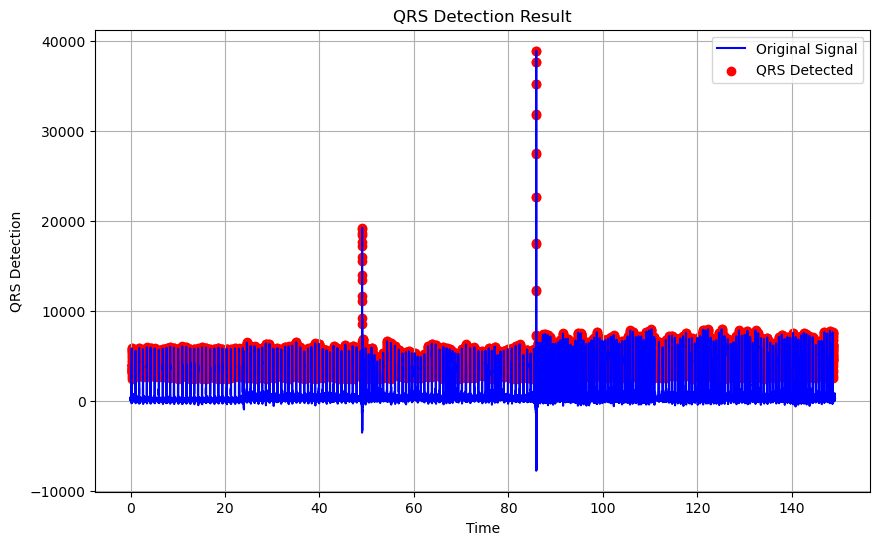

In [1191]:
# Get the time column
time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

[x_data, y_data] = rate_of_change(time, data)

# Create a DataFrame for the rate of change
rate_of_change_df = pd.DataFrame({'Rate_of_change': y_data})

# Concatenate the rate of change DataFrame with the original dataset
df = pd.concat([df, rate_of_change_df], axis=1)

# Find the QRS Complexes thorugh rate of change
[qrs_x, qrs_y_binary, qrs_y] = qrs_detection(x_data, y_data)

# QRS Binary data frame
qrs_df_binary = pd.DataFrame({'QRS_detected_binary': qrs_y_binary})

# Add them to the dataset 
df = pd.concat([df, qrs_df_binary], axis=1)

## Preprocessing Pipeline


In [1192]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [1193]:
# Assuming numerical_columns and categorical_columns are lists of column names
numerical_columns = df.select_dtypes(include='number').columns.to_list()

#exclude the target from numerical columns
numerical_columns.remove("QRS_detected_binary")

# Create preprocessing pipeline for numerical columns
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

# Combine preprocessing pipelines for numerical columns
preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns)],
    remainder='passthrough')

# Display the preprocessing pipeline
preprocessing_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['sec', 'CH1', 'Rate_of_change'])])

In [1194]:
# # Apply the preprocessing pipeline on the dataset
df_prepared = preprocessing_pipeline.fit_transform(df)

# Scikit-learn strips the column headers in most cases, so just add them back on afterward.
feature_names=preprocessing_pipeline.get_feature_names_out()
df_prepared = pd.DataFrame(data=df_prepared, columns=feature_names)

df_prepared

,numerical__sec,numerical__CH1,numerical__Rate_of_change,remainder__QRS_detected_binary
0,0.000,-0.120850,293.305396,0.0
1,0.001,-0.123596,317.500967,0.0
2,0.002,-0.126343,342.372504,0.0
3,0.003,-0.129395,366.793208,0.0
4,0.004,-0.131836,389.479583,0.0
...,...,...,...,...
149115,149.115,-0.089111,206.511459,0.0
149116,149.116,-0.088501,218.141564,0.0
149117,149.117,-0.087891,232.782147,0.0
149118,149.118,-0.086975,250.380349,0.0


## Splitting Data into Training and Testing Data (80%)

In [1195]:
from sklearn.model_selection import train_test_split

X = df_prepared.drop(["remainder__QRS_detected_binary"], axis=1)
y = df_prepared["remainder__QRS_detected_binary"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(104384, 3) (104384,) (44736, 3) (44736,)


# Applying a Linear Regression Model to the dataset

In [1196]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
import xgboost as xgb

# lr_model = LinearRegression()
# lr_model = DecisionTreeRegressor()
# lr_model = RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=10, min_samples_split=10)
# lr_model = GradientBoostingRegressor(random_state=42, n_estimators=2000, max_depth = 3, max_features = 3, min_samples_split = 10)
lr_model = xgb.XGBClassifier()
# training the model on the training data
lr_model.fit(x_train,y_train)

# Make predictions on the test set
y_pred = lr_model.predict(x_test)

# Evaluate thlr_e model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9999329399141631


## Model Performance

In [1197]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

### MSE Value

In [1198]:
def get_mse (model, x, y) : 
    y_pred = model.predict(x)
    return mean_squared_error(y,y_pred)

### RMSE Value

In [1199]:
def get_rmse(model, x, y) : 
    y_pred = model.predict(x)
    return np.sqrt(get_mse(model, x, y))

### MAE Value

In [1200]:
def get_mae(model, x, y) : 
    y_pred = model.predict(x)
    return mean_absolute_error(y, y_pred)

### R2 Value

In [1201]:
from sklearn.metrics import r2_score

def get_r2(model, x, y) : 
    y_pred = model.predict(x)
    return r2_score(y,y_pred)

# Performance Visualization


## Training Outputs

In [1202]:
mse_lr_train = get_mse(lr_model, x_train, y_train)
rmse_lr_train = get_rmse(lr_model, x_train, y_train)
mae_lr_train = get_mae(lr_model, x_train, y_train)
lr_r2_train = get_r2(lr_model, x_train, y_train)

col = ["mse", "MAE", "RMSE", "R2"]
ind = ['LinerRegression']
con = [[mse_lr_train, mae_lr_train, rmse_lr_train,lr_r2_train]]
pd.DataFrame(con, columns=col, index = ind)

,mse,MAE,RMSE,R2
LinerRegression,0.000019,0.000019,0.004377,0.999631


## Testing Outputs

In [1203]:
lr_model.fit(x_test,y_test)
mse_lr_test = get_mse(lr_model, x_test ,y_test) 
mae_lr_test = get_mae(lr_model, x_test, y_test)
rmse_lr_test = get_rmse(lr_model, x_test, y_test)
lr_r2_test = r2_score(y_test, lr_model.predict(x_test))

col = ["mse", "MAE", "RMSE", "R2"]
ind = ['LinerRegression']
con = [[mse_lr_test, mae_lr_test, rmse_lr_test,lr_r2_test]]
pd.DataFrame(con, columns=col, index = ind)

,mse,MAE,RMSE,R2
LinerRegression,0.000022,0.000022,0.004728,0.999576


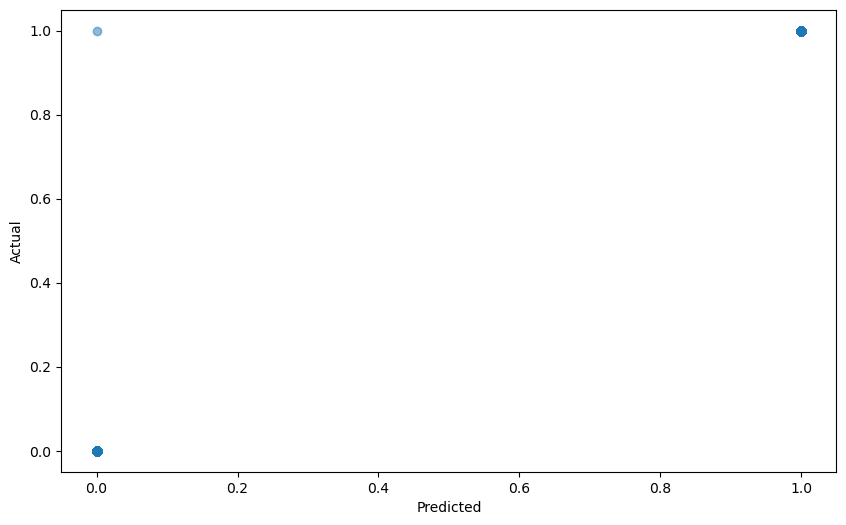

In [1204]:
def plot_scatter(model) : 
    y_pred = model.predict(x_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, y_test, alpha=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_scatter(lr_model)

[249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 347

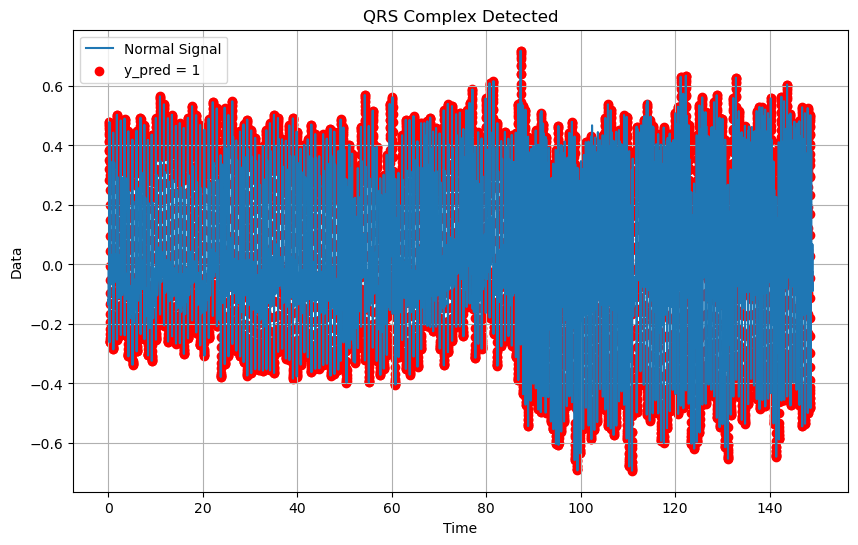

In [1205]:
data = df_prepared.drop(["remainder__QRS_detected_binary"], axis=1)

# Separate features and target variable
X = df_prepared[['numerical__CH1', 'numerical__sec','numerical__Rate_of_change']]
y = df_prepared['remainder__QRS_detected_binary']

lr_model.fit(X,y)
y_pred = lr_model.predict(X)

# Find the indexes where y_pred equals 1
indexes = [i for i, pred in enumerate(y_pred) if pred == 1]

# Plot the normal signal
plt.figure(figsize=(10, 6))
plt.plot(data["numerical__sec"], data["numerical__CH1"], label='Normal Signal')

# Plot markers where y_pred equals 1
plt.scatter((data["numerical__sec"])[indexes], data["numerical__CH1"][indexes], color='red', label='y_pred = 1')

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('QRS Complex Detected')
plt.legend()
plt.grid(True)
plt.show()

# Trying the Trained Model on other Datasets:
For this we will be using one of our datasets from lab 3

In [1206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset with comma as delimiter
df = pd.read_csv("Mahdin_Lab3-L05.txt", sep="\t")

df = df.iloc[:3000]

df['sec'] = df['sec'].apply(lambda x: float(x.split()[0])) #Mahdin's Dataset was exported with tab as adelimiter making the sec column a string, here we are converting it back to a float64

df.head()

C:\Users\joaqu\AppData\Local\Temp\ipykernel_11352\374175750.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Mahdin_Lab3-L05.txt", sep="\t")


,sec,CH1,CH40,Unnamed: 3
0,0.000,0.000000,NaN,NaN
1,0.001,0.122986,0.0,NaN
2,0.002,0.107422,0.0,NaN
3,0.003,0.091858,0.0,NaN
4,0.004,0.076904,0.0,NaN


In [1207]:
# Removing unnecessary columns
df = df.drop('Unnamed: 3', axis=1) # Unnecessary
df = df.drop('CH40', axis=1)

df.head()

,sec,CH1
0,0.000,0.000000
1,0.001,0.122986
2,0.002,0.107422
3,0.003,0.091858
4,0.004,0.076904


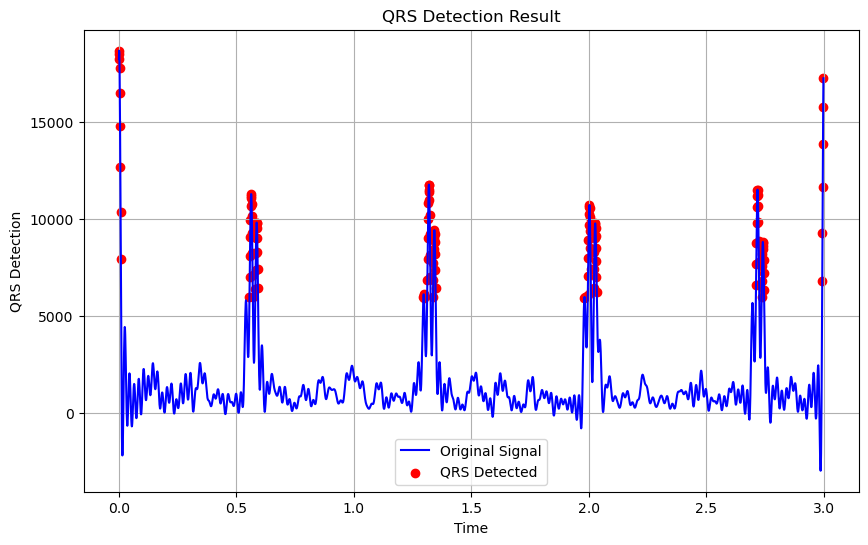

In [1208]:
# Get the time column
time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

[x_data, y_data] = rate_of_change(time, data)

# Create a DataFrame for the rate of change
rate_of_change_df = pd.DataFrame({'Rate_of_change': y_data})

# Concatenate the rate of change DataFrame with the original dataset
df = pd.concat([df, rate_of_change_df], axis=1)

# Find the QRS Complexes thorugh rate of change
[qrs_x, qrs_y_binary, qrs_y] = qrs_detection(x_data, y_data)

# QRS Binary data frame
qrs_df_binary = pd.DataFrame({'QRS_detected_binary': qrs_y_binary})

# Add them to the dataset 
df = pd.concat([df, qrs_df_binary], axis=1)

In [1209]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [1210]:
# Assuming numerical_columns and categorical_columns are lists of column names
numerical_columns = df.select_dtypes(include='number').columns.to_list()

#exclude the target from numerical columns
numerical_columns.remove("QRS_detected_binary")

# Create preprocessing pipeline for numerical columns
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))])


# Combine preprocessing pipelines for numerical columns
preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns)],
    remainder='passthrough')

# Display the preprocessing pipeline
preprocessing_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['sec', 'CH1', 'Rate_of_change'])])

In [1211]:
# # Apply the preprocessing pipeline on the dataset
df_prepared = preprocessing_pipeline.fit_transform(df)

# Scikit-learn strips the column headers in most cases, so just add them back on afterward.
feature_names=preprocessing_pipeline.get_feature_names_out()
df_prepared = pd.DataFrame(data=df_prepared, columns=feature_names)

df_prepared

,numerical__sec,numerical__CH1,numerical__Rate_of_change,remainder__QRS_detected_binary
0,0.000,0.000000,18247.472440,1.0
1,0.001,0.122986,18676.309800,1.0
2,0.002,0.107422,18516.988569,1.0
3,0.003,0.091858,17779.040608,1.0
4,0.004,0.076904,16507.118167,1.0
...,...,...,...,...
2995,2.995,-0.182495,9259.902182,1.0
2996,2.996,-0.185852,11646.282856,1.0
2997,2.997,-0.188904,13855.988208,1.0
2998,2.998,-0.190430,15763.166109,1.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 1296, 1297, 1298, 1299, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1981, 1982, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2994, 2995, 2996, 2997, 2998, 2999]


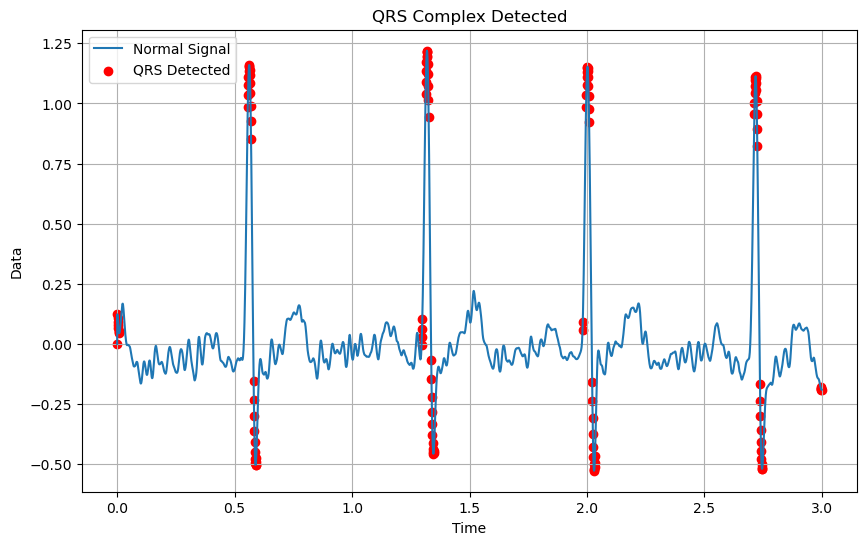

In [1212]:
time = df_prepared.drop(["remainder__QRS_detected_binary"], axis=1)

# Separate features and target variable
X = df_prepared[['numerical__CH1', 'numerical__sec','numerical__Rate_of_change']]
y = df_prepared['remainder__QRS_detected_binary']

lr_model.fit(X,y)
y_pred = lr_model.predict(X)

# Find the indexes where y_pred equals 1
indexes = [i for i, pred in enumerate(y_pred) if pred == 1]

# Plot the normal signal
plt.figure(figsize=(10, 6))
plt.plot(time["numerical__sec"], time["numerical__CH1"], label='Normal Signal')

# Plot markers where y_pred equals 1
plt.scatter((time["numerical__sec"])[indexes], time["numerical__CH1"][indexes], color='red', label='QRS Detected')

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('QRS Complex Detected')
plt.legend()
plt.grid(True)
plt.show()